In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
from glob import glob
import numpy as np

In [3]:
example_data = pd.read_csv('ssrt_metrics/indiv_guesses.csv', index_col=0)
example_data.columns = example_data.columns.str.replace('SSRT_', '')
melt_df = pd.melt(example_data, id_vars=['SSD'], value_vars=['SSRT','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')

In [ ]:
example_data

In [ ]:
_ = sns.lineplot(x='SSD', y='SSRT', hue='assumed_go_dist', data=melt_df)

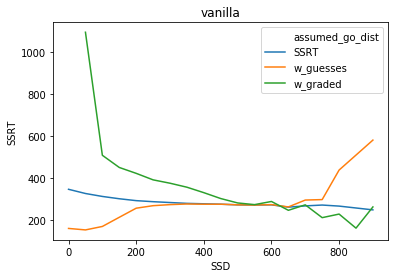

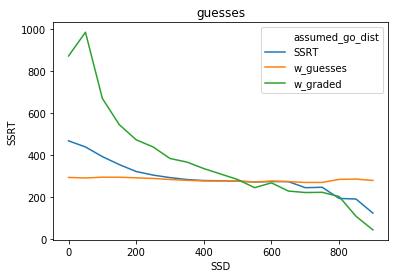

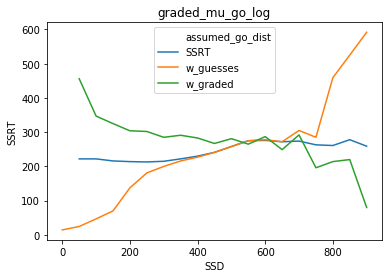

In [4]:
p_respond_df = pd.DataFrame(index = example_data.mean_SSD)

for file in [i for i in glob('ssrt_metrics/indiv_*.csv') if 'linear' not in i]:
    data =  pd.read_csv(file, index_col=0)
    data.columns = data.columns.str.replace('SSRT_', '')
    data.rename(columns={'SSRT': 'standard'})
    melt_df = pd.melt(data, id_vars=['SSD'], value_vars=['SSRT','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')
    _ = sns.lineplot(x='SSD', y='SSRT', hue='assumption', data=melt_df)
    title = file.split('indiv_')[-1].replace('.csv', '')
    plt.title(title)
    plt.show()
    plt.close()
    
    curr_series = data.loc[:,['mean_SSD', 'p_respond']].set_index('mean_SSD').add_prefix(title+'_')
    p_respond_df = pd.concat([p_respond_df, curr_series], 1)

In [ ]:
p_respond_df